*Credits: Applied Data Analysis (ADA) course at EPFL (https://dlab.epfl.ch/teaching/fall2020/cs401/)*

## Unsupervised Learning exercise

Now that we have learned about clustering and dimensionality reduction techniques, let's apply those into a real world example!

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

<img src="img/wheat_banner.png" width="800">

Data Set Information:

> The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

Source: https://archive.ics.uci.edu/ml/datasets/seeds



First, load the data _seeds\_dataset.csv_

In [2]:
seeds = pd.read_csv('data/seeds_dataset.csv', sep=',')
seeds.head()

,ID,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,1,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,2,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,3,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,4,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,5,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In this exercise, we are interested in discovering structure in the data by hiding the actual label provided in the dataset.

### Prepare the dataset

We will create a dataset by keeping only the meaningful features. As a result, remove the _ID_ and _seedType_ columns.

In [9]:
#seeds_features = seeds[['area','perimeter','compactness','lengthOfKernel','widthOfKernel','asymmetryCoefficient','lengthOfKernelGroove']]
seeds_features = seeds.drop(["ID", 'seedType'], axis='columns')
seeds_features.head()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


Plot the histogram of the different features. We will do this for you.

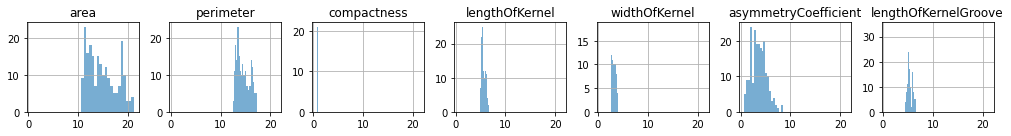

In [10]:
columns = seeds_features.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=True)

for column_idx in range(0, len(columns)):
    seeds_features[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    
plt.tight_layout()

Do you notice anything in particular regarding the values of the different features?

**Solution below**

The features have different value scales, and this is not ideal since it can lead to them having different importance in the algorithm.

For example let's say you are measuring distance between data points with features $u$ (ranging [0, 1]) and $t$ (ranging [0, 1000]). We define the points $p1=(0, 500)$, $p2=(1, 500)$ and $p3=(1, 510)$. If not properly scaled, point $p2$ will be closer to $p1$ than to $p3$, while relatively speaking the latter should be more similar.

We will mitigate this problem, by normalizing the data. There are different ways to normalize a dataset, but in this case we will use the `StandardScaler` function implemented by `sklearn`. This function standardizes features by removing the mean and scaling to unit variance. Check out more in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Declare a StandardScaler and fit it with our data features.

In [11]:
# Declare the scaler
scaler = StandardScaler()
# Fit it
scaler.fit(seeds_features)

StandardScaler()

Scale the features. You can use the `.transform()` function for this.

In [12]:
# Scale the features
scaled_features = scaler.transform(seeds_features)

print("Scaled sample: %s" %scaled_features[0])

Scaled sample: [ 1.42097769e-01  2.15462437e-01  6.06017918e-05  3.04218199e-01

  1.41701823e-01 -9.86151745e-01 -3.83577423e-01]


### Cluster the data with K-Means

Firstly, we need to find the most suitable value of K. For this, we will use the Elbow method.

The function below computes the SSE for different values of K, and plots its distribution. Complete ir by declaring a K-Means model for each value, training it using the training data, and extracting the SSE.

*Hint:* the kmeans object has an attribute containing the Sum of Squared Errors. Check again the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to find this out.

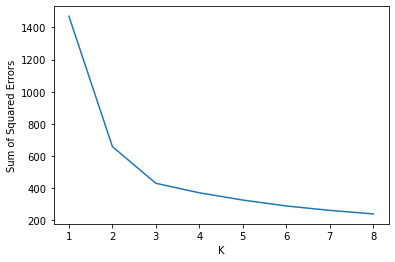

In [14]:
def plot_sse(features_X, start=1, end=9):
    sse_array = []
    for k in range(start, end):
        '''
        FILL IN YOUR CODE HERE
        '''
        # Declare the K-Means model. Choose random_state=10
        kmeans = KMeans(n_clusters=k, random_state=10)
        # Train it
        kmeans.fit(features_X)
        # Extract the Sum of Squared Errors
        sse = kmeans.inertia_
        
        sse_array.append({"k": k, "sse": sse})

    sse_array = pd.DataFrame(sse_array)
    # Plot the data
    plt.plot(sse_array.k, sse_array.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(scaled_features)

Based on your findings, make a guess of what should be the appropriate value for `K`.

In [15]:
optimal_k = 3

### Visualize your clusters

First, print the number of features considered for this problem

In [26]:
# add your code here
len(seeds_features.columns)

7

Visualizing data with these dimensions is not possible. We need a dimensionality reduction technique to be able to plot this in 2d.

Let's make use of [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Therefore a t-SNE model with a 2-dimensional embedded space. For this, use sklearn's built-in function TSNE. Set random_state=0.

In [27]:
tsne = TSNE(n_components=2, random_state=0)

Now, extract the embedded features. For this, you can make use of the `.fit_transform()` function.

In [36]:
X_reduced_tsne = tsne.fit_transform(scaled_features)

C:\Users\CE PC\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  warnings.warn(

C:\Users\CE PC\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  warnings.warn(


Declare a K-Means model with the optimal number of clusters you have found. Set random_state=0.

In [37]:
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

Fit the model to the data.

In [38]:
kmeans.fit(scaled_features)

KMeans(n_clusters=3, random_state=0)

Extract the labels from each datapoint. *Hint*: check out the `.predict()` function.

In [39]:
labels = kmeans.predict(scaled_features)

Let's plot the resulting clusters, together with the original seed types!

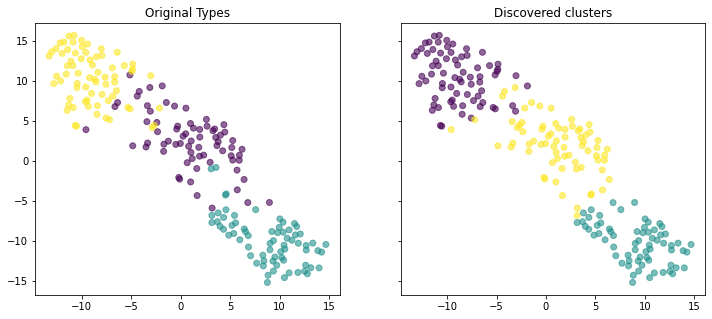

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Plot the original seed types
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=seeds.seedType, alpha=0.6)
axs[0].set_title("Original Types")

# Plot the clusters discovered based on the structure of the data
axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("Discovered clusters")

plt.show()